In [32]:
OPENSLIDE_PATH = r'C:\Users\kim\Desktop\bsm\pathology_image_project\git_ignore\openslide-win64-20230414\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        from openslide import OpenSlide, ImageSlide
        import openslide
else:
    from openslide import OpenSlide, ImageSlide
    import openslide

In [33]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pandas as pd
import tifffile as tiff


## 파라미터 설정

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [36]:
CFG = {
    'IMG_SIZE':512,
    'BATCH_SIZE': 20,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'pth' : r"data/pthfile/2023_06_20/train:10X_epoch:20_12:55_PM.pth"
}

In [37]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [38]:
# 현재 시각
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_06_20 02:48_PM


In [39]:
# server path
svspath = r"data/PDA_svs_img/test/C3L-01637-21.svs"
output_path = f"data/output/{day}"
figure_path = f"{output_path}/figure"
test_data_path = r"data/PDA_tile_img/test_512/C3L-01637-21/C3L-01637-21_tiles"
tsv_path = r"data/PDA_tile_img/test_512/C3L-01637-21/tile_selection.tsv"


## 데이터 불러오기

In [40]:
slide = openslide.OpenSlide(svspath)
dimension = slide.dimensions

In [41]:
table = pd.read_csv(tsv_path, sep='\t')
table[:5]

Tile  Width  Height  Keep  Row  Column
0  C3L-01637-21_000    512     512     0    0       0
1  C3L-01637-21_001    512     512     0    0       1
2  C3L-01637-21_002    512     512     0    0       2
3  C3L-01637-21_003    512     512     0    0       3
4  C3L-01637-21_004    512     512     0    0       4

In [42]:
# 전체 타일 이미지 불러오기
test_img = glob.glob(f"{test_data_path}/*")
img_split_dict = {}
for index, name in enumerate(table["Tile"]):
    img_split_dict[name] = cv2.imread(sorted(test_img)[index])

In [43]:
# Tissue 타일 이미지만 추출
tile_name = table[table["Keep"]==1]["Tile"]
tile_path = list(test_data_path+'/'+tile_name+".png")

## 패치 데이터 Load

In [44]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, path, name, transform = None):
        self.image = path
        self.transform = transform
        self.name = list(name)

    def __len__(self):
        return len(self.image)  # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        transformed = self.transform(image = image)
        image = transformed["image"]
        name = self.name[i]
        return image, name

In [45]:
test_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2()
])

In [46]:
# 테스트 데이터
test_set = CustomDataset(path= tile_path,
                         name = tile_name,
                         transform = test_transform)

In [47]:
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [48]:
print(f"test_data : {len(test_set)}")

test_data : 173


## Test

In [49]:
# Modeling
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

In [50]:
# 학습 파라미터
model = ResUNet(num_classes=1).to(device)
model = nn.DataParallel(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
model.load_state_dict(torch.load(CFG['pth'], map_location=device))

<All keys matched successfully>

In [52]:
# Test
def Test(model, test_loader, device):
    model.eval()
    label_dict = {}
    with torch.no_grad():
        for img, name in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            output = pred.cpu().detach().numpy().astype(int)
            for name, output in zip(name, output):
                label_dict[name] = output
        return label_dict

In [53]:
label_dict = Test(model, test_loader, device)

  0%|          | 0/9 [00:00<?, ?it/s]

## 패치 하나로 합치기

In [54]:
def convert_grayscale_to_bgr(grayscale_image):
    # Convert grayscale image to RGB
    rgb_image = np.repeat(grayscale_image[:, :, np.newaxis], 3, axis=2)
    return rgb_image

In [55]:
def apply_mask_image1(image, label, alpha=0.7):
    """픽셀별로 mask 적용하기

    Args:
        image: 각 픽셀 값
        color: 클래스 별 masking color 값을 행으로 하는 행렬 (8x3)
        alpha: 투명도 [0,1]

    Returns:
        image에 mask 입힌 이미지 반환
    """
    # mask이미지 3채널 변환 후 색 입히기
    for key, value in label.items():
        label[key] = convert_grayscale_to_bgr(value) * np.array([89, 244, 255])

    for key1, value1 in tqdm(image.items()):
        for key2, value2 in label.items():
            value2 = value2.astype(np.uint8)
            if key1 == key2:
                if value1.shape != value2.shape: # 이미지 크기 맞추기
                    value2 = cv2.resize(value2.astype(float), (value1.shape[1], value1.shape[0]), interpolation=cv2.INTER_LINEAR)
                # 마스크가 적용된 부분만 계산합니다.
                mask1 = value2 > 0
                mask1 = mask1.astype(value1.dtype)
                # mask가 적용된 부분은 마스크로 계산합니다.
                masked_image1 = cv2.multiply(value1, mask1)
                masked_image2 = cv2.addWeighted(masked_image1, alpha, value2, 1.0 - alpha, 0)
                
                # mask가 적용되지 않은 부분은 원본 이미지에서 가져옵니다.
                mask2 = value2 == 0
                mask2 = mask2.astype(value1.dtype)
                masked_image3 = cv2.multiply(value1, mask2)

                # mask가 적용된 부분과 mask가 적용되지 않은 부분을 합성합니다.
                result_image = cv2.add(masked_image2, masked_image3)
                image[key1] = result_image
    image = dict(sorted(image.items(), key=lambda x:x[0]))
    return image

In [56]:
def apply_mask_image2(image, label, alpha=0.3):
    """픽셀별로 mask 적용하기

    Args:
        image: 각 픽셀 값
        color: 클래스 별 masking color 값을 행으로 하는 행렬 (8x3)
        alpha: 투명도 [0,1]

    Returns:
        image에 mask 입힌 이미지 반환
    """
    # mask이미지 3채널 변환
    for key, value in label.items():
        label[key] = convert_grayscale_to_bgr(value) * np.array([255, 255, 255])

    for key1, value1 in tqdm(image.items()):
        result_image = (1 - alpha) * value1
        image[key1] = result_image
        for key2, value2 in label.items():
            value2 = value2.astype(np.uint8)
            if key1 == key2:
                if value1.shape != value2.shape:
                    value2 = cv2.resize(value2.astype(float), (value1.shape[1], value1.shape[0]), interpolation=cv2.INTER_LINEAR)
                result_image = (1 - alpha) * value1 + alpha * value2
                image[key1] = result_image
    image = dict(sorted(image.items(), key=lambda x:x[0]))
    
    return image

In [57]:
def image_crop_list_to_total_image(img_split_dict, table, dimension):
    # masking한 패치 이미지를 다시 전체 슬라이드 이미지로 합치기

    # 전체 슬라이드 이미지와 같은 크기의 영행렬 생성
    out_image_array = np.zeros((dimension[1],dimension[0], 3), dtype = np.uint8)

    # masking 된 패치 이미지로 이루어진 전체 슬라이드 이미지 생성
    x = 0
    y = 0
    for key, value in (img_split_dict.items()):
        column = int(table[table["Tile"]==key]["Column"])
        row = int(table[table["Tile"]==key]["Row"])
        if column == 0 and row!=0:
            x = 0
            y = y+height
        width = int(table[table["Tile"]==key]["Width"])
        height = int(table[table["Tile"]==key]["Height"])

        out_image_array[y:y+height,x:x+width] = value
        x = x+width
    return out_image_array

In [58]:
# 패치 별 mask 오버레이(overlay)
img_split_dict = apply_mask_image2(img_split_dict, label_dict)

  0%|          | 0/832 [00:00<?, ?it/s]

In [59]:
# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(img_split_dict, table, dimension)
merge_image_rgb = merge_image[...,::-1]

test_merge_image = Image.fromarray(merge_image_rgb) # PIL이미지로 변환

# 시각화를 위해 사이즈 줄이기
resize_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))

In [60]:
merge_image.shape

(12960, 15935, 3)

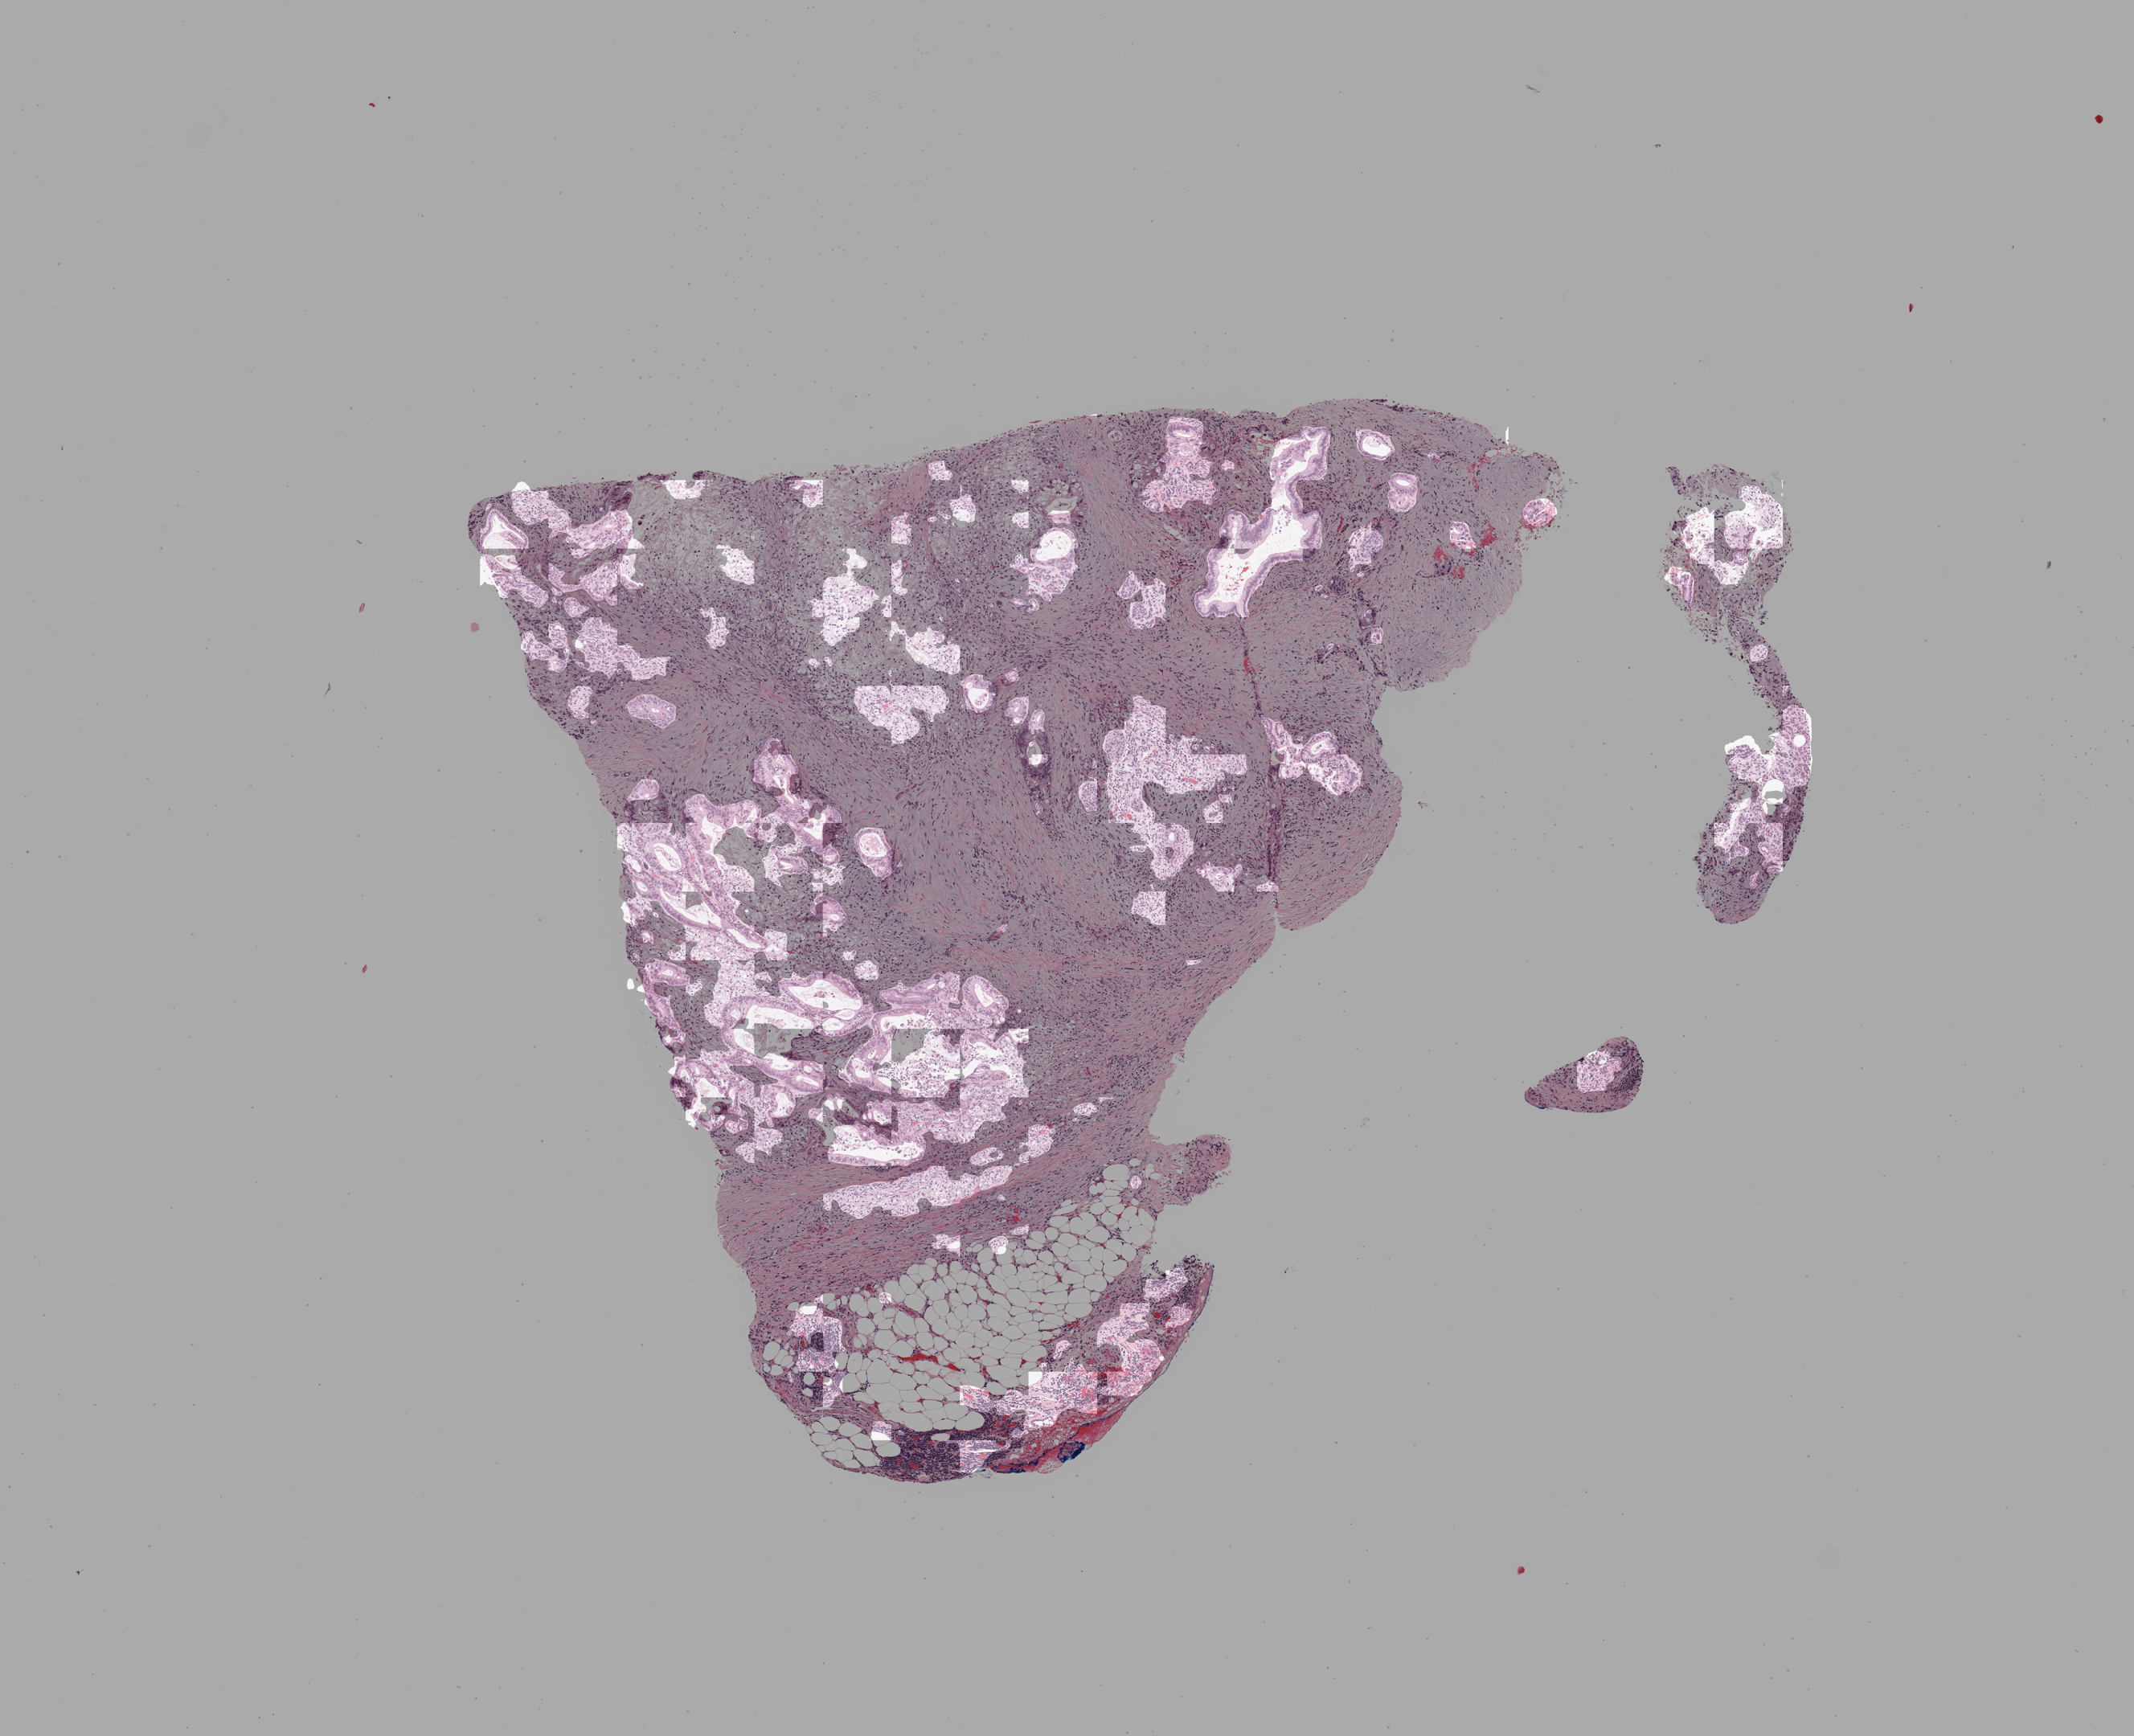

In [61]:
resize_image

## 이미지 tiff 저장

In [62]:
os.makedirs(f"{figure_path}", exist_ok=True)
tiff.imsave(f"{figure_path}/test_segmentation_512(10x).tiff",merge_image_rgb)


/tmp/ipykernel_125913/689874325.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(f"{figure_path}/test_segmentation_512(10x).tiff",merge_image_rgb)
